<h2>1. Introduction</h2>

This IBM Sample Dataset has information about Telco customers and if they left the company within the last month (churn). Each row represents a unique costumer, while the columns contains information about customer’s services, account and demographic data. We will be using Python and Seaborn library to plot and analyze the data.

**Basic information**:
* Only 7043 rows
* There are 21 columns with 19 features
* Only 11 missing values (next item).

You can also check: [Predicting churn - logistic regression and SVM](https://www.kaggle.com/jsaguiar/predicting-churn-complete-tutorial-logit-vs-svm)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")
df = pd.read_csv("../datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


<h3>1.1 Impute missing values</h3>

There are only 11 missing values, all of them for the TotalCharges column. This values are actually a blank space in the csv file and are exclusive for customers with zero tenure. It's possible to concluded that they are missing due to the fact that the customer never paied anything to the company. We will impute this missing values with zero:

In [4]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

<h3>1.2 Target variable</h3>

We are trying to predict if the client left the company in the previous month. Therefore we have a binary classification problem with a slightly unbalanced target:
* Churn: No   - 72.4%
* Churn: Yes  - 27.6%

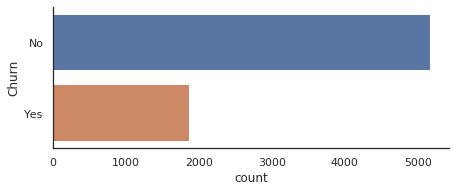

In [5]:
ax = sns.catplot(y="Churn", kind="count", data=df, height=2.6, aspect=2.5, orient='h')

<h2>2. Numerical features</h2>

There are only three numerical columns: tenure, monthly charges and total charges. The probability density distribution can be estimate using the seaborn kdeplot function. 

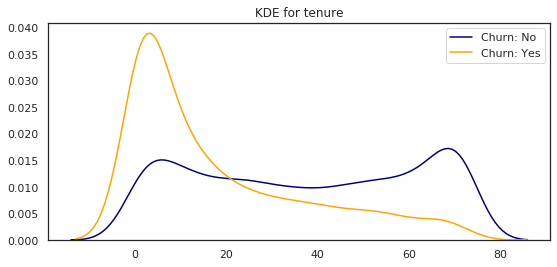

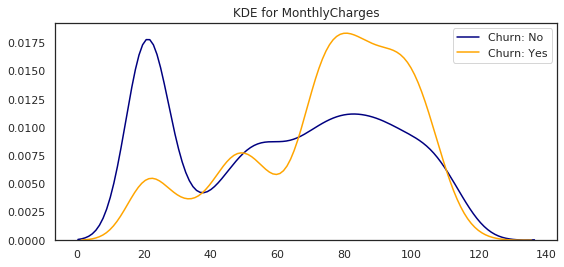

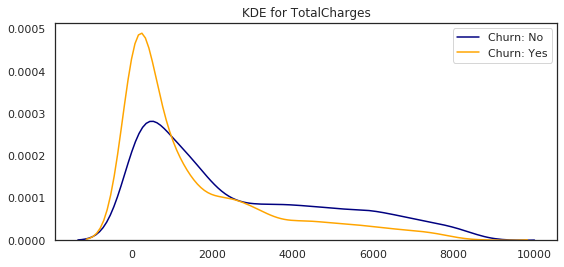

In [6]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

From the plots above we can conclude that:
* Recent clients are more likely to churn
* Clients with higher MonthlyCharges are also more likely to churn
* Tenure and MonthlyCharges are probably important features

In fact we can see some boundaries when we use scatter plots:

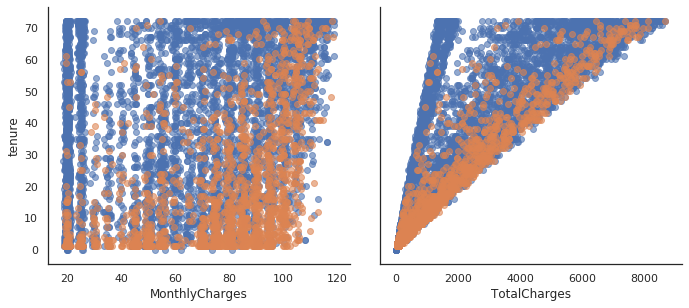

In [7]:
g = sns.PairGrid(df, y_vars=["tenure"], x_vars=["MonthlyCharges", "TotalCharges"], height=4.5, hue="Churn", aspect=1.1)
ax = g.map(plt.scatter, alpha=0.6)

Another feature we can consider is the difference between the MonthlyCharges and the TotalCharges divided by the tenure:

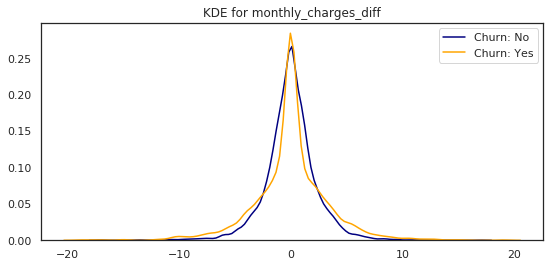

In [8]:
# Calculate features
df['total_charges_to_tenure_ratio'] = df['TotalCharges'] / df['tenure']
df['monthly_charges_diff'] = df['MonthlyCharges'] - df['total_charges_to_tenure_ratio']
kdeplot('monthly_charges_diff')

Not a promising feature at first glance, but it might be usefull when combined with categorical features.


<h2>3. Categorical features</h2>

This dataset has 16 categorical features:

* Six binary features (Yes/No)
* Nine features with three unique values each (categories)
* One feature with four unique values

<h3>3.1 Gender and Age (SeniorCitizen)</h3>

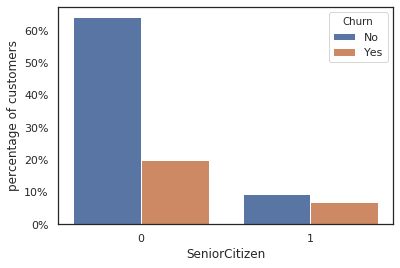

In [11]:
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = df.groupby(feature)["Churn"].value_counts().to_frame()
    g = g.rename({"Churn": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("SeniorCitizen")

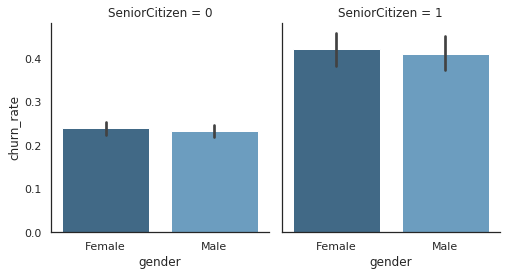

In [12]:
df['churn_rate'] = df['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(df, col="SeniorCitizen", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "churn_rate", palette = "Blues_d", order= ['Female', 'Male'])

In [ ]:
g = sns.FacetGrid(df, row='SeniorCitizen', col="gender", hue="Churn", height=3.5)
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.6)
g.add_legend();

* Gender is not an indicative of churn. 
* SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers. 
* There are no special relations between this categorical values and the main numerical features.

<h3>3.2 Partner and dependents</h3>

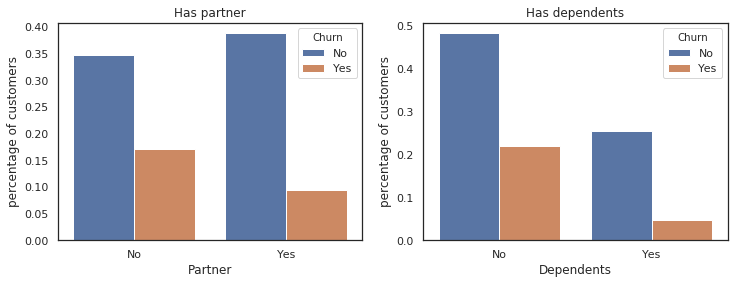

In [10]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"
# Plot Partner column
gp_partner = df.groupby('Partner')["Churn"].value_counts()/len(df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
# Plot Dependents column
gp_dep = df.groupby('Dependents')["Churn"].value_counts()/len(df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

* Customers that doesn't have partners are more likely to churn
* Customers without dependents are also more likely to churn

<h3>3.3 Phone and Internet services</h3>

Now let's look at the services that customers are using. There are only two main services: phone and internet but the former has many additionals like online backup and security.

<b>Phone services</b>

There are only two features here: if the client has phone and if he has more than one line. Both can be summed up in one chart:

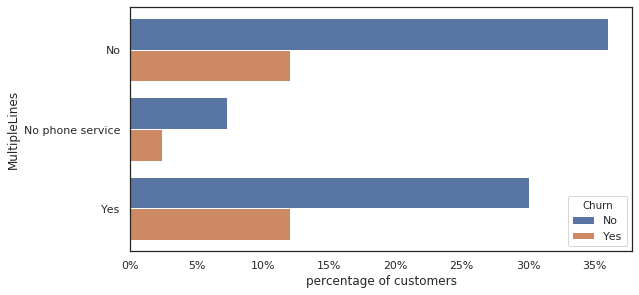

In [13]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("MultipleLines", orient='h')

* Few customers doesn't have phone service
* Customers with multiple lines have a slightly higher churn rate

Let's see how multiple lines affects the monthly charges:

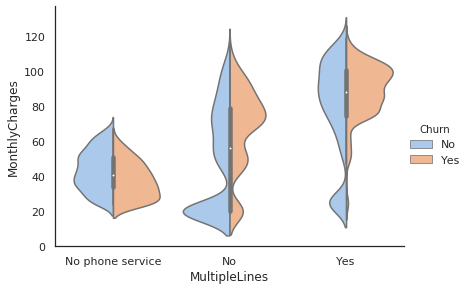

In [14]:
ax = sns.catplot(x="MultipleLines", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

<b>Internet services</b>

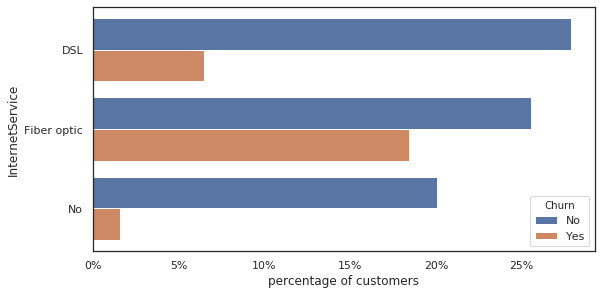

In [15]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="h")

* Clients without internet have a very low churn rate
* Customers with fiber are more probable to churn than those with DSL connection

Comparing the Internet service with monthly charges:

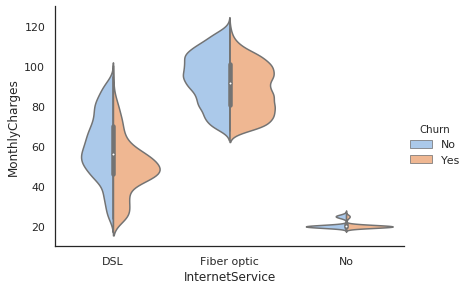

In [16]:
ax = sns.catplot(x="InternetService", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4);

It's interesting how customers with DSL (slower connection) and higher charges are less probable to churn. 

**Additional services**

There are six additional services for customers with internet:

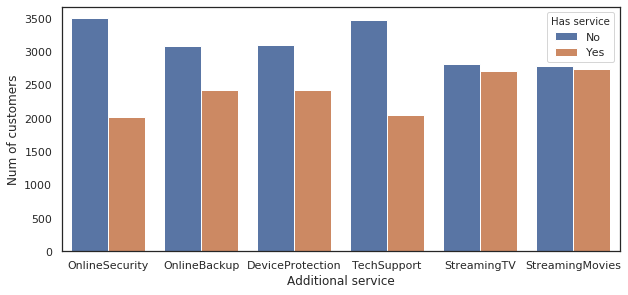

In [18]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(df[df["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

In [ ]:
plt.figure(figsize=(10, 4.5))
df1 = df[(df.InternetService != "No") & (df.Churn == "Yes")]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

The first plot shows the total number of customers for each additional service, while the second shows the number of clients that churn. We can see that:

* Customers with the first 4 additionals (security to tech support) are more unlikely to churn
* Streaming service is not predictive for churn

<h3>3.4 Contract and Payment</h3>

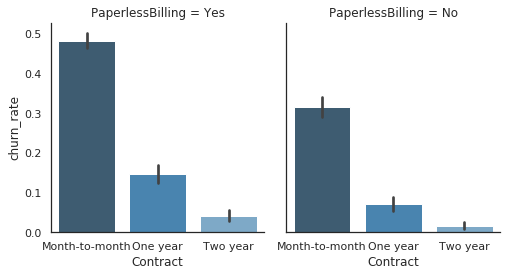

In [19]:
g = sns.FacetGrid(df, col="PaperlessBilling", height=4, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order= ['Month-to-month', 'One year', 'Two year'])

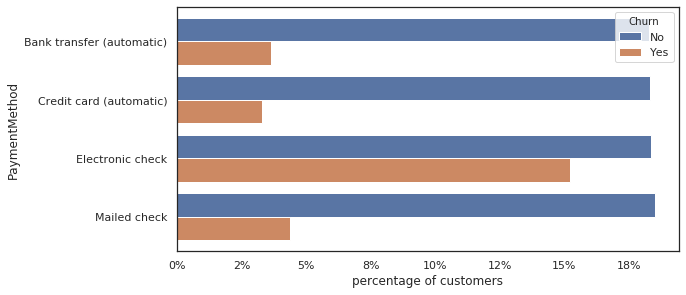

In [20]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod", orient='h')

A few observations:
* Customers with paperless billing are more probable to churn
* The preferred payment method is Electronic check with around 35% of customers. This method also has a very high churn rate
* Short term contracts have higher churn rates

One and two year contracts probably have contractual fines and therefore customers have to wait untill the end of contract to churn. A time-series dataset would be better to understand this kind of behaviour. Now let's have a look at the relation with numerical features:

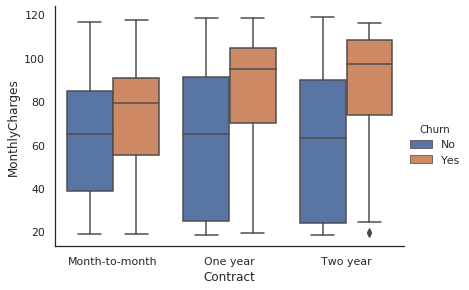

In [21]:
ax = sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=df, height=4.2, aspect=1.4)

In [ ]:
ax = sns.catplot(y="Churn", x="MonthlyCharges", row="PaymentMethod", kind="box", data=df, height=1.5, aspect=4, orient='h')

* Longer contracts are more affected by higher monthly charges (for churn rate).
* Mailed checks have lower charges
* There is a huge gap in charges between customers that churn and those that don't with respect to Mailed Check

<h2>4. Correlation between features</h2>

Correlation heatmap (Pearson method)

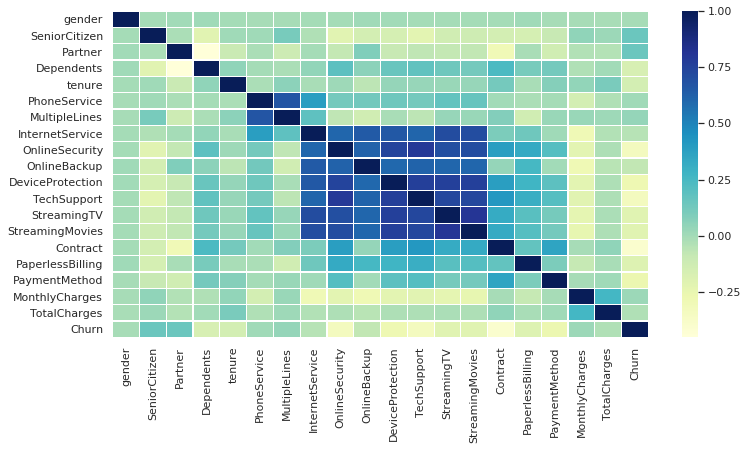

In [22]:
plt.figure(figsize=(12, 6))
df.drop(['customerID', 'churn_rate', 'total_charges_to_tenure_ratio', 'monthly_charges_diff'],
        axis=1, inplace=True)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

<h2>5. Feature Importance</h2>

To get some preliminary feature importances we will use the Random Forest classifier, an well know decision-tree based model.  I've used one-hot encode to encode the categorical features and dropped the 'No' columns for binary features. I've also manually tested a few hyperparameters to get a better model.

The importances are the mean decrease in impurity for each feature across all trees.

In [ ]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
df = pd.get_dummies(df)
# Drop redundant columns (for features with two unique values)
drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No',
        'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No']
x, y = df.drop(drop,axis=1), df['Churn_Yes']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

The importances are in line with our previous analysis. The three numerical features are good predictors for churn, specially tenure. As we've seen, customers with Fiber optic are very likely to churn, while those with long term contracts are not. On the other hand, gender and streaming are not important features and It might be interesting to drop additional services with the label 'No internet service', since they are highly correlated.

Please leave your feedback and suggestions. 

You can also check: [Predicting churn - logistic regression and SVM](https://www.kaggle.com/jsaguiar/predicting-churn-complete-tutorial-logit-vs-svm)